In [1]:
import time
import yaml
import torch
from utils import *
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image
from astropy.io import fits
from model.BrownianBridge.base.modules.diffusionmodules.openaimodel import UNetModel
from model.BrownianBridge.BrownianBridgeModel import BrownianBridgeModel as BBDM
import imageio.v3 as iio
import matplotlib.animation as animation


torch.xpu.empty_cache()
%matplotlib widget

In [7]:
video_array = iio.imread('./fire.mp4')

video_list = []

for frame in video_array:
    mirrored = np.flipud(frame)
    result = np.vstack([frame, mirrored])
    video_list.append(rescale(result, 1024))

# final = np.array(video_list)
n = 112
# y = np2torch(im).float() / 255.0

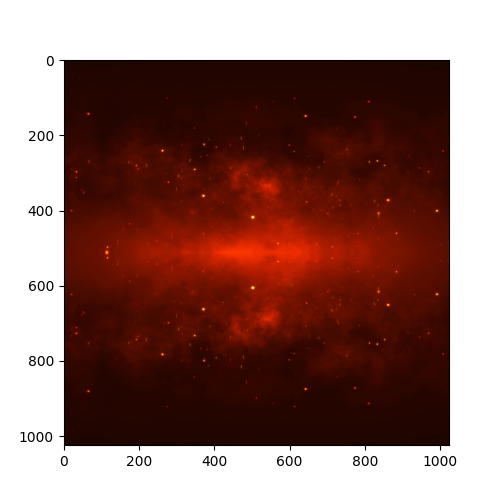

In [9]:
image_d(video_list[100])

In [11]:
# video2mp4(video_list, './video.mp4') 

In [8]:
# Load the .npz file
video_list = []

with np.load('./video.npz') as data:
    # Convert all arrays in the file to a list
    v = [data[key] for key in data.files]

video = v[0]

for frame in video:
    video_list.append(frame)

In [4]:
# video2mp4(video, './output.mp4', fps=24)

In [2]:
# traget frame
image = Image.open('lat.png')
img = np.array(image)
lat_palette = image.palette
raw_palette = lat_palette.getdata()[1]
palette_array = np.frombuffer(raw_palette, dtype=np.uint8).reshape(-1, 3)  # shape: (256, 3)
colored = palette_array[img][:,900:2700,:]
x = rescale(np2torch(colored).float(), 1024) / 255.0

# condition frame
video_array = iio.imread('./fire.mp4')  # Returns NumPy array directly 
n = 112
im = video_array[n][1080//2-512:1080//2+512, 1920//2-512:1920//2+512,:]
y = np2torch(im).float() / 255.0

In [7]:
# get_h('./imgs/sci.fits')

Mean: -0.017076313495635986  STD: 0.17498643696308136
Mean: 0.008110187016427517  STD: 0.10930544137954712


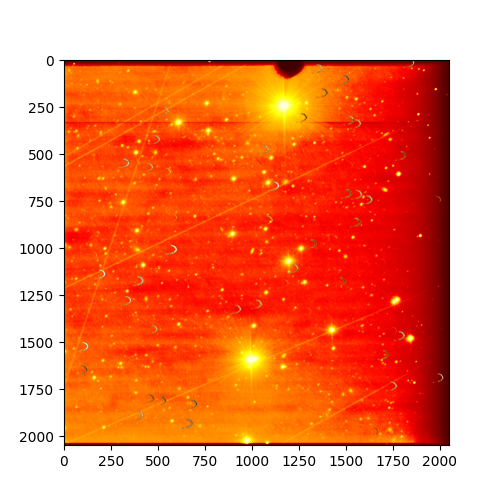

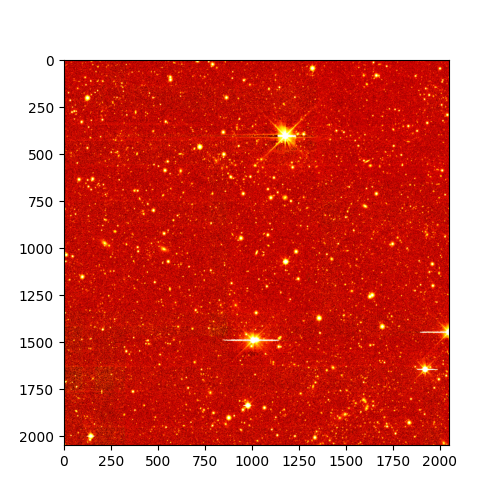

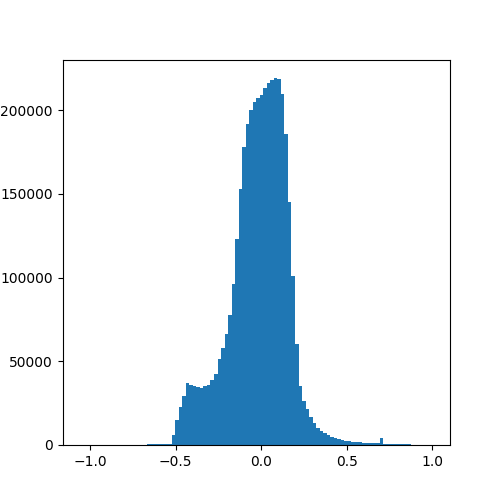

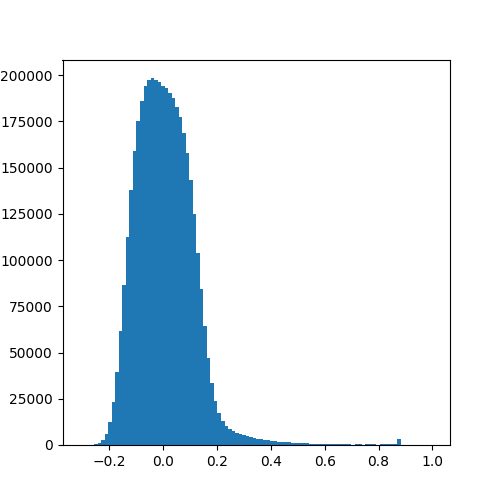

In [12]:
sci = np.arcsinh((get_d('./imgs/sci.fits') - np.median(get_d('./imgs/sci.fits'))) / 10000)
sci /= sci.max()

ref = np.arcsinh((get_d('./imgs/ref.fits') - np.median(get_d('./imgs/ref.fits'))) / .005)
ref /= ref.max()

image_d(sci, cmap='hot')
image_d(ref, cmap='hot')

hist(sci)
hist(ref)

In [4]:
def run(ngc, config_f="./configs/config.yaml", 
        mx=128, my=128, mxw=24, myw=24, transient=False, flux=10):
    
    # config file
    with open(config_f, "r") as file:
        config = dict2namespace(yaml.load(file, Loader=yaml.FullLoader)) 

    im_size = config.data.dataset_config.image_size
    batch_size = config.data.train.batch_size
    tile_size = config.data.train.tile_size
    n_tiles = int((im_size / tile_size)**2)
    
    # inpainting mask
    m = np.ones((im_size, im_size))
    m[my - myw // 2:my + myw // 2, mx - mxw // 2:mx + mxw // 2] = 0
    
    # science image
    ddd1 = np.flip(np.nan_to_num(get_d('./imgs/' + str(ngc) + '_sdss.fits')), axis=0) 
    dd1 = rescale(change_order(ddd1), (im_size, im_size))[:,:,0]
    dd1 -= np.median(dd1)
    
    if transient:
        dd1 = add_transient(ddd1, x=mx, y=my, flux=flux, fwhm=5)
    else:
        dd1 = ddd1.copy()
        
    dd1 /= dd1.max()
    d1 = 1 - (1 - dd1)**100

    # gt image
    gt = d1.copy()
    
    # masked gt image
    gtm = gt * m
    
    # reference image
    dd2 = np.flip(np.nan_to_num(get_d('./imgs/' + str(ngc) + '_ps.fits')), axis=0)
    dd2 /= dd2.max()
    d2 = rescale(change_order(dd2), (im_size, im_size))[:,:,0]

    # images
    xx = np2torch(gtm.astype(float).copy()).to(config.training.device).float()
    yy = np2torch(d2.astype(float).copy()).to(config.training.device).float()
    mm = np2torch(m.astype(float).copy()).to(config.training.device).float()
    orig_shape = xx.shape
    
    # tiling
    x_tiles = get_tiles(xx, config.data.train.tile_size)
    y_tiles = get_tiles(yy, config.data.train.tile_size)
    m_tiles = get_tiles(mm, config.data.train.tile_size)
    
    # model
    model = BBDM(config.model).to(config.training.device)
    losses = []
    count_params(model)

    # gt contrast
    zscale = ZScaleInterval(contrast=.02)
    z1, z2 = zscale.get_limits(gt)
    
    # ground truth image
    save_img(gt, './checks/' + str(ngc) + '/gt.png', 
             mx=mx, my=my, mw=mxw, vmin=z1, vmax=z2)
    
    # masked image
    save_img(gtm, './checks/' + str(ngc) + '/gtm.png', 
             mx=mx, my=my, mw=mxw, vmin=z1, vmax=z2)
    
    # condition image
    save_img(d2, './checks/' + str(ngc) + '/condition.png', 
               contrast=.02)
    
    # nuber of diffusion timesteps
    n_timesteps = config.training.n_steps
    
    # Total number of iterations
    n_iters = 35001
    
    # Decay starts after 100 iterations
    decay_start_iter = 20000
    
    def custom_decay(step):
        if step < decay_start_iter:
            return 1.0  # Maintain initial learning rate
        else:
            # Linear decay from step 100 to total_iters
            decay_factor = (n_iters - step) / (n_iters - decay_start_iter)
            return max(decay_factor, 0.0)  # Ensure non-negative factor
    
    # Prepare the optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
    
    # Initialize the learning rate scheduler
    lr_scheduler = LambdaLR(optimizer, lr_lambda=custom_decay)
    
    start_time = time.time()
    
    for iter in range(n_iters):

        # Randomly shuffle tile indices for better training
        indices = torch.randperm(n_tiles)
        batch_indices = indices[:batch_size]  # Pick N random tiles

        x_batch = x_tiles[batch_indices]
        y_batch = y_tiles[batch_indices]
        m_batch = m_tiles[batch_indices]
        
        t = torch.randint(0, n_timesteps, (1,), device=config.training.device)  # Random timestep
        
        # Calculate loss (MSE)
        loss = model.p_losses(x0=x_batch, y=y_batch, context=None, t=t, m=m_batch)[0]
        losses.append(loss.item())
        
        if iter % 50 == 0:
            print(f"Iter [{iter+1}/{n_iters}], Loss: {loss.item():.4f}, Time: {np.round(time.time() - start_time, 2)}, Lr: {optimizer.param_groups[0]['lr']}")
    
        # saving intermediate images
        if iter % 5000 == 0 and iter != 0:

            start = 0
            tiles_list = []
            
            for i in range(int(len(y_tiles) // batch_size)):   # [0:5], [5:9], [9:13], [13:17]
                
                end = start + batch_size
                y_batch = y_tiles[start:end]
                
                out = model.sample(y_batch)   
                tiles_list.append(out)    

                start = end

            out_tiles = torch.cat(tiles_list)
            final_tiles = torch.unsqueeze(out_tiles, 0)
            array_data = torch2np(merge_tiles(final_tiles, orig_shape, tile_size))[:, :, 0]
            
            # Save the image to a PNG file            
            save_img(array_data, './checks/' + str(ngc) + '/' + str(iter) + '_image.png', 
                     mx=mx, my=my, mw=mxw, vmin=z1, vmax=z2)
    
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        # Update learning rate
        lr_scheduler.step()
        
    return model, losses, array_data

In [5]:
# live image test
def run(name, x, y, config_f="./configs/config.yaml"):
    
    # config file
    with open(config_f, "r") as file:
        config = dict2namespace(yaml.load(file, Loader=yaml.FullLoader)) 

    im_size = config.data.dataset_config.image_size
    batch_size = config.data.train.batch_size
    tile_size = config.data.train.tile_size
    n_tiles = int((im_size / tile_size)**2)

    # science image
    xx = x.to(config.training.device).float()
    yy = y.to(config.training.device).float()
    orig_shape = xx.shape
    
    # tiling
    x_tiles = get_tiles(xx, config.data.train.tile_size)
    y_tiles = get_tiles(yy, config.data.train.tile_size)
    
    # model
    model = BBDM(config.model).to(config.training.device)
    losses = []
    count_params(model)

    # gt contrast
    gt = torch2np(x)
    zscale = ZScaleInterval(contrast=.2)
    z1, z2 = zscale.get_limits(gt)

    # condition image
    condition = torch2np(y)
    
    # ground truth image
    save_img(gt, './checks/' + str(name) + '/gt.png', vmin=z1, vmax=z2)
        
    # condition image
    save_img(condition, './checks/' + str(name) + '/condition.png', contrast=.2)
    
    # nuber of diffusion timesteps
    n_timesteps = config.training.n_steps
    
    # Total number of iterations
    n_iters = 2001
    
    # Decay starts after 100 iterations
    decay_start_iter = 1000
    
    def custom_decay(step):
        if step < decay_start_iter:
            return 1.0  # Maintain initial learning rate
        else:
            # Linear decay from step 100 to total_iters
            decay_factor = (n_iters - step) / (n_iters - decay_start_iter)
            return max(decay_factor, 0.0)  # Ensure non-negative factor
    
    # Prepare the optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
    
    # Initialize the learning rate scheduler
    lr_scheduler = LambdaLR(optimizer, lr_lambda=custom_decay)
    
    start_time = time.time()
    
    for iter in range(n_iters):

        # Randomly shuffle tile indices for better training
        indices = torch.randperm(n_tiles)
        batch_indices = indices[:batch_size]  # Pick N random tiles

        x_batch = x_tiles[batch_indices]
        y_batch = y_tiles[batch_indices]
        
        t = torch.randint(0, n_timesteps, (1,), device=config.training.device)  # Random timestep
        
        # Calculate loss (MSE)
        loss = model.p_losses(x0=x_batch, y=y_batch, context=None, t=t)[0]
        losses.append(loss.item())
        
        if iter % 50 == 0:
            print(f"Iter [{iter+1}/{n_iters}], Loss: {loss.item():.4f}, Time: {np.round(time.time() - start_time, 2)}, Lr: {optimizer.param_groups[0]['lr']}")
    
        # saving intermediate images
        if iter % 1000 == 0 and iter != 0:

            start = 0
            tiles_list = []
            
            for i in range(int(len(y_tiles) // batch_size)):   # [0:5], [5:9], [9:13], [13:17]
                
                end = start + batch_size
                y_batch = y_tiles[start:end]
                
                out = model.sample(y_batch)   
                tiles_list.append(out)    

                start = end

            out_tiles = torch.cat(tiles_list)
            final_tiles = torch.unsqueeze(out_tiles, 0)
            array_data = torch2np(merge_tiles(final_tiles, orig_shape, tile_size))
            
            # Save output and differenct images to a PNG file            
            save_img(array_data, './checks/' + str(name) + '/' + str(iter) + '.png', vmin=z1, vmax=z2)

            # save_img(difference, './checks/' + str(name) + '/' + str(iter) + '_difference.png', 
            #          mx=mx, my=my, mw=mxw, vmin=z1, vmax=z2)
    
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        # Update learning rate
        lr_scheduler.step()
        
    return model, losses, array_data

In [6]:
model, losses, array_data = run(name='lat', x=x, y=y) 

907.859 parameters
Iter [1/2001], Loss: 0.1285, Time: 5.49, Lr: 0.0002
Iter [51/2001], Loss: 0.0465, Time: 18.66, Lr: 0.0002
Iter [101/2001], Loss: 0.0039, Time: 26.66, Lr: 0.0002
Iter [151/2001], Loss: 0.0052, Time: 34.52, Lr: 0.0002
Iter [201/2001], Loss: 0.0098, Time: 42.4, Lr: 0.0002
Iter [251/2001], Loss: 0.0024, Time: 49.72, Lr: 0.0002
Iter [301/2001], Loss: 0.0033, Time: 57.05, Lr: 0.0002
Iter [351/2001], Loss: 0.0069, Time: 64.4, Lr: 0.0002
Iter [401/2001], Loss: 0.0102, Time: 72.19, Lr: 0.0002
Iter [451/2001], Loss: 0.0064, Time: 79.71, Lr: 0.0002
Iter [501/2001], Loss: 0.0083, Time: 86.96, Lr: 0.0002
Iter [551/2001], Loss: 0.0101, Time: 94.5, Lr: 0.0002
Iter [601/2001], Loss: 0.0020, Time: 102.39, Lr: 0.0002
Iter [651/2001], Loss: 0.0052, Time: 110.02, Lr: 0.0002
Iter [701/2001], Loss: 0.0022, Time: 117.6, Lr: 0.0002
Iter [751/2001], Loss: 0.0066, Time: 125.09, Lr: 0.0002
Iter [801/2001], Loss: 0.0146, Time: 132.36, Lr: 0.0002
Iter [851/2001], Loss: 0.0061, Time: 139.53, Lr: 

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Iter [1051/2001], Loss: 0.0068, Time: 521.77, Lr: 0.00019000999000999002
Iter [1101/2001], Loss: 0.0057, Time: 529.29, Lr: 0.00018001998001998003
Iter [1151/2001], Loss: 0.0056, Time: 537.7, Lr: 0.00017002997002997004
Iter [1201/2001], Loss: 0.0016, Time: 544.73, Lr: 0.00016003996003996005
Iter [1251/2001], Loss: 0.0037, Time: 551.62, Lr: 0.00015004995004995006
Iter [1301/2001], Loss: 0.0009, Time: 558.5, Lr: 0.00014005994005994007
Iter [1351/2001], Loss: 0.0062, Time: 565.47, Lr: 0.00013006993006993008
Iter [1401/2001], Loss: 0.0010, Time: 572.35, Lr: 0.00012007992007992009
Iter [1451/2001], Loss: 0.0088, Time: 579.27, Lr: 0.0001100899100899101
Iter [1501/2001], Loss: 0.0032, Time: 586.22, Lr: 0.00010009990009990011
Iter [1551/2001], Loss: 0.0055, Time: 593.15, Lr: 9.010989010989012e-05
Iter [1601/2001], Loss: 0.0077, Time: 600.33, Lr: 8.011988011988012e-05
Iter [1651/2001], Loss: 0.0040, Time: 607.2, Lr: 7.012987012987014e-05
Iter [1701/2001], Loss: 0.0020, Time: 614.13, Lr: 6.013986

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


In [3]:
# with open('./configs/config.yaml', "r") as file:
#     config = dict2namespace(yaml.load(file, Loader=yaml.FullLoader)) 

# model = BBDM(config.model).to(config.training.device)
# checkpoint = torch.load('./bbdm_checkpoint.pth', map_location=torch.device('xpu'))  # load checkpoint
# model.load_state_dict(checkpoint)

In [4]:
# run(ngc=4565, mx=512+80, my=512-200, mxw=100, myw=100)   
# model, losses, rec = run(ngc=4565, mx=660, my=360, mxw=100, myw=100) 

(1024, 1024, 1)

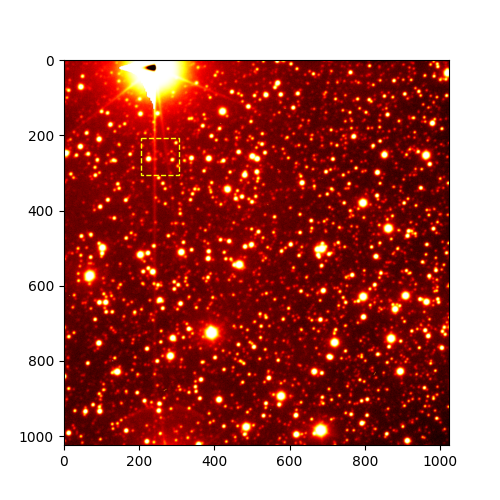

In [14]:
im_size = 1024
# ngc = 4594

# ddd1 = np.flip(np.nan_to_num(get_d('./imgs/' + str(ngc) + '_sdss.fits')), axis=0) 
# dd1 = rescale(change_order(ddd1), (1024, 1024))[:,:,0]
# dd1 = add_transient(dd1, x=660, y=360, flux=10, fwhm=5)
# d1 = np.asinh((dd1 - np.mean(dd1)))

dd1 = fixnan(get_d('./imgs/sci.fits'))
dd1 -= np.median(dd1)
dd1 /= dd1.max()
d1 = 1 - (1 - dd1)**50

xx = np2torch(d1.astype(float).copy())
x_n = torch2np(xx)

# d2 = np.flip(np.nan_to_num(get_d('./imgs/' + str(ngc) + '_ps.fits')), axis=0)
d2 = fixnan(get_d('./imgs/ref.fits'))
d2 /= d2.max()
# d2 *= (1 / np.std(d2))

y = np2torch(d2.astype(float).copy())
# y = rescale(yy, im_size).float()
# y_n = torch2np(y)
y_n = d2.copy()

mx = 256
my = 256
mxw = 100
myw = 100

m = np.ones(x_n.shape)
m[my - myw // 2:my + myw // 2, mx - mxw // 2:mx + mxw // 2] = 0

# problem star
# m[275-16:275+16, 490-16:490+16] = 0

image_d(x_n, mx=256, my=256, mw=100, contrast=.02, cmap='hot')
# save_img(x_n, './contr.png', contrast=.02)
x_n.shape

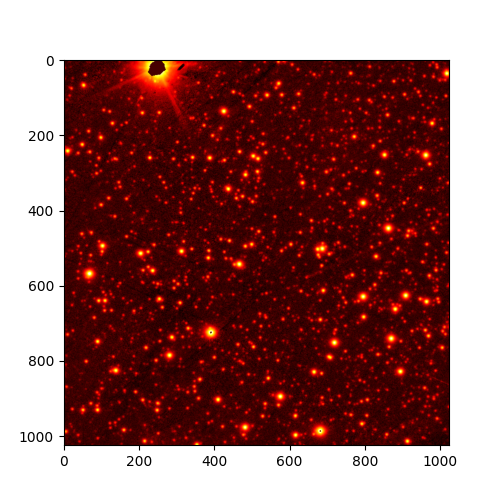

In [15]:
image_d(y_n, contrast=.02, cmap='hot')

Mean: 0.019505516309834547  STD: 0.09722945324999797
Mean: 0.02246752195060253  STD: 0.09113151580095291


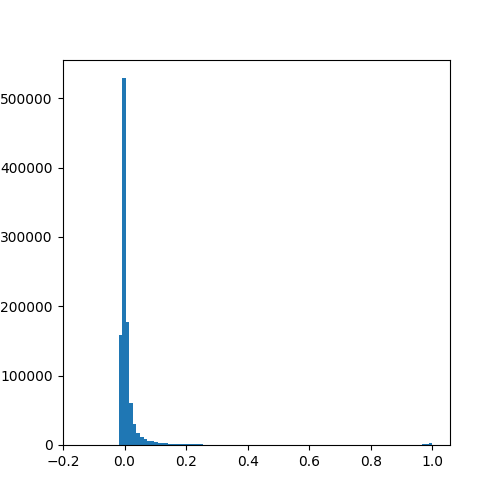

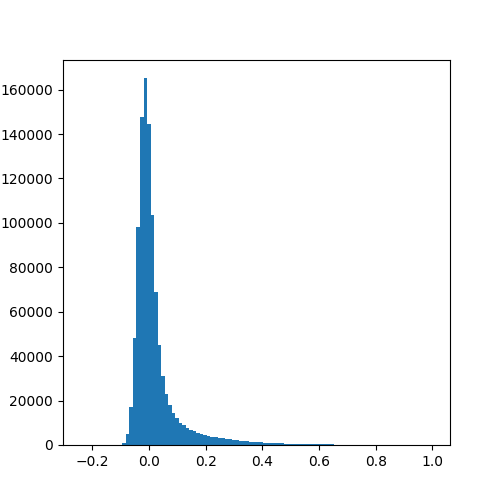

In [11]:
hist(x_n)
hist(y_n)

In [ ]:
def run2(ngc, config_f="./configs/config.yaml", 
        mx=256, my=256, mxw=100, myw=100, transient=False, flux=10):
    
    # config file
    with open(config_f, "r") as file:
        config = dict2namespace(yaml.load(file, Loader=yaml.FullLoader)) 

    im_size = config.data.dataset_config.image_size
    batch_size = config.data.train.batch_size
    tile_size = config.data.train.tile_size
    n_tiles = int((im_size / tile_size)**2)
    
    # inpainting mask
    m = np.ones((im_size, im_size))
    m[my - myw // 2:my + myw // 2, mx - mxw // 2:mx + mxw // 2] = 0
    
    # science image
    dd1 = fixnan(get_d('./imgs/sci.fits'))
    dd1 -= np.median(dd1)
    dd1 /= dd1.max()
    d1 = 1 - (1 - dd1)**50
    
    # gt image
    gt = d1.copy()
    
    # masked gt image
    gtm = gt * m
    
    # reference image
    d2 = fixnan(get_d('./imgs/ref.fits'))
    d2 /= d2.max()

    # images
    xx = np2torch(gtm.astype(float).copy()).to(config.training.device).float()
    yy = np2torch(d2.astype(float).copy()).to(config.training.device).float()
    mm = np2torch(m.astype(float).copy()).to(config.training.device).float()
    orig_shape = xx.shape
    
    # tiling
    x_tiles = get_tiles(xx, config.data.train.tile_size)
    y_tiles = get_tiles(yy, config.data.train.tile_size)
    m_tiles = get_tiles(mm, config.data.train.tile_size)
    
    # model
    model = BBDM(config.model).to(config.training.device)
    losses = []
    count_params(model)

    # gt contrast
    zscale = ZScaleInterval(contrast=.02)
    z1, z2 = zscale.get_limits(gt)
    
    # ground truth image
    save_img(gt, './checks/' + str(ngc) + '/gt.png', 
             mx=mx, my=my, mw=mxw, vmin=z1, vmax=z2)
    
    # masked image
    save_img(gtm, './checks/' + str(ngc) + '/gtm.png', 
             mx=mx, my=my, mw=mxw, vmin=z1, vmax=z2)
    
    # condition image
    save_img(d2, './checks/' + str(ngc) + '/condition.png', 
               contrast=.02)
    
    # nuber of diffusion timesteps
    n_timesteps = config.training.n_steps
    
    # Total number of iterations
    n_iters = 35001
    
    # Decay starts after 100 iterations
    decay_start_iter = 20000
    
    def custom_decay(step):
        if step < decay_start_iter:
            return 1.0  # Maintain initial learning rate
        else:
            # Linear decay from step 100 to total_iters
            decay_factor = (n_iters - step) / (n_iters - decay_start_iter)
            return max(decay_factor, 0.0)  # Ensure non-negative factor
    
    # Prepare the optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
    
    # Initialize the learning rate scheduler
    lr_scheduler = LambdaLR(optimizer, lr_lambda=custom_decay)
    
    start_time = time.time()
    
    for iter in range(n_iters):

        # Randomly shuffle tile indices for better training
        indices = torch.randperm(n_tiles)
        batch_indices = indices[:batch_size]  # Pick N random tiles

        x_batch = x_tiles[batch_indices]
        y_batch = y_tiles[batch_indices]
        m_batch = m_tiles[batch_indices]
        
        t = torch.randint(0, n_timesteps, (1,), device=config.training.device)  # Random timestep
        
        # Calculate loss (MSE)
        loss = model.p_losses(x0=x_batch, y=y_batch, context=None, t=t, m=m_batch)[0]
        losses.append(loss.item())
        
        if iter % 50 == 0:
            print(f"Iter [{iter+1}/{n_iters}], Loss: {loss.item():.4f}, Time: {np.round(time.time() - start_time, 2)}, Lr: {optimizer.param_groups[0]['lr']}")
    
        # saving intermediate images
        if iter % 5000 == 0 and iter != 0:

            start = 0
            tiles_list = []
            
            for i in range(int(len(y_tiles) // batch_size)):   # [0:5], [5:9], [9:13], [13:17]
                
                end = start + batch_size
                y_batch = y_tiles[start:end]
                
                out = model.sample(y_batch)   
                tiles_list.append(out)    

                start = end

            out_tiles = torch.cat(tiles_list)
            final_tiles = torch.unsqueeze(out_tiles, 0)
            array_data = torch2np(merge_tiles(final_tiles, orig_shape, tile_size))[:, :, 0]
            
            # Save the image to a PNG file            
            save_img(array_data, './checks/' + str(ngc) + '/' + str(iter) + '_image.png', 
                     mx=mx, my=my, mw=mxw, vmin=z1, vmax=z2)
    
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        # Update learning rate
        lr_scheduler.step()
        
    return model, losses, array_data

In [23]:
run2(mx=512, my=512, mxw=100, myw=100)

In [26]:
# s = split_1024(x_n*m)
# me = merge_256_1024(s)

# image_d(s[6], cmap='hot', contrast=.01)
# image_d(s[3], cmap='hot', contrast=.0001)

In [27]:
# run(ngc=4565, mx=512+80, my=512-200, mw=100)

In [ ]:
# model, losses = run(ngc=4594, mx=128+70, my=128-2, mxw=28, myw=28)

In [ ]:
# run2(ngc=4565, mx=256-80, my=256+80, mxw=70, myw=70)

In [ ]:
# run(ngc=3705, mx=100, my=132, mxw=24, myw=24)

In [ ]:
# run(ngc=2967, mx=128, my=128+28, mxw=24, myw=24) 

In [8]:
with open("./configs/config.yaml", "r") as file: 
    config = dict2namespace(yaml.load(file, Loader=yaml.FullLoader))  # Use safe_load for security 

In [9]:
# image 
im_size = config.data.dataset_config.image_size 
# img_path = "./imgs/dark.jpg" 
# img = Image.open(img_path).convert("RGB")
# imgn = np.array(img)[:, 190:670, 0] / 255
# x = rescale(np2torch(imgn), im_size).to(config.training.device).float()


xx = np2torch(d1.astype(float).copy())
x = rescale(xx, im_size).to(config.training.device).float()

# x1 = torch.rot90(x0, k=1, dims=(0, 1))
# x2 = torch.rot90(x0, k=2, dims=(0, 1))
# x3 = torch.rot90(x0, k=3, dims=(0, 1))
# x = torch.cat([x0, x1, x2, x3])


# conditional image
# c_img_path = "./imgs/black.jpg"
# c_img = Image.open(c_img_path).convert("RGB")
# c_imgn = np.array(c_img)[:, 190:670, 0] / 255
# y = rescale(np2torch(c_imgn), im_size).to(config.training.device).float()


yy = np2torch(d2.astype(float).copy())
y = rescale(yy, im_size).to(config.training.device).float()

# y1 = torch.rot90(y0, k=1, dims=(0, 1))
# y2 = torch.rot90(y0, k=2, dims=(0, 1))
# y3 = torch.rot90(y0, k=3, dims=(0, 1))
# y = torch.cat([y0, y1, y2, y3])
              
# mask for 256
mx = 128 + 85
my = 128  + 10
mxw = 24   
myw = 24 

# mask for 128
# mx = 66 
# my = 70  
# mxw = 16   
# myw = 35 

m = torch.ones(1, 1, im_size, im_size)
m[0, :, my - myw // 2:my + myw // 2, mx - mxw // 2:mx + mxw // 2] = 0
mt = m.to(config.training.device).float()

x_orig = x.detach().clone()
# mt1 = torch.rot90(mt0, k=1, dims=(0, 1))
# mt2 = torch.rot90(mt0, k=1, dims=(0, 1))
# mt3 = torch.rot90(mt0, k=1, dims=(0, 1))
# mt = torch.cat([mt0, mt1, mt2, mt3])

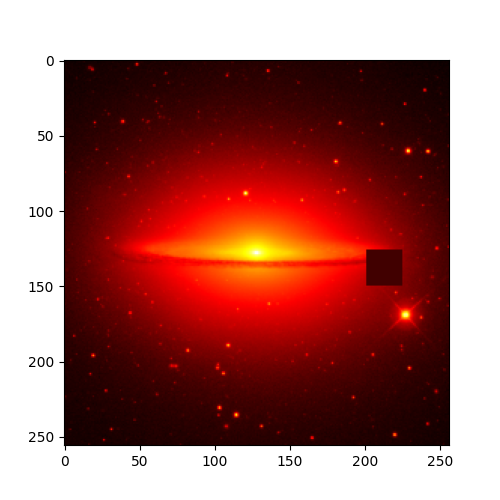

In [10]:
image_d(torch2np(x * mt), cmap='hot')

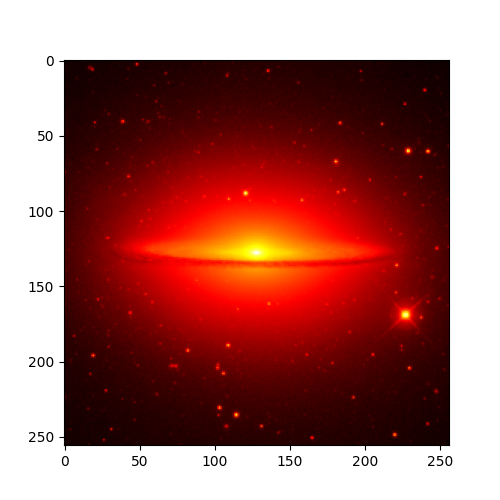

In [11]:
image_d(torch2np(x), cmap='hot')

In [12]:
# image_d(torch2np(x), cmap='hot')

In [13]:
model = BBDM(config.model).to(config.training.device)
count_params(model)

2.036.761 parameters


In [14]:
losses = []

# ground truth
plt.imsave('./checks/4569/gt.png', torch2np(x_orig)[:,:,0], cmap='hot')

# a nuber of diffusion timesteps
n_timesteps = config.training.n_steps

# Total number of iterations
# n_iters = config.training.n_iters
n_iters = 20001

# Decay starts after 100 iterations
decay_start_iter = 10000

def custom_decay(step):
    if step < decay_start_iter:
        return 1.0  # Maintain initial learning rate
    else:
        # Linear decay from step 100 to total_iters
        decay_factor = (n_iters - step) / (n_iters - decay_start_iter)
        return max(decay_factor, 0.0)  # Ensure non-negative factor

# Prepare the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Initialize the learning rate scheduler
lr_scheduler = LambdaLR(optimizer, lr_lambda=custom_decay)

start_time = time.time()

for iter in range(n_iters):
    
    t = torch.randint(0, n_timesteps, (1,), device=config.training.device)  # Random timestep
    
    # Calculate loss (MSE)
    loss = model.p_losses(x0=x, y=y, context=None, t=t, m=mt)[0]
    losses.append(loss.item())
    
    if iter % 50 == 0:
        print(f"Iter [{iter+1}/{n_iters}], Loss: {loss.item():.4f}, Time: {np.round(time.time() - start_time, 2)}, Lr: {optimizer.param_groups[0]['lr']}")

    # saving intermediate images
    if iter % 1000 == 0 and iter != 0:
        # array_data = torch2np(model.sample(x))[:, :, 0] * 100
        # image = Image.fromarray(array_data.astype(np.uint8),  mode="L")
        
        array_data = torch2np(model.sample(y))[:, :, 0]
        
        # Save the image to a PNG file
        # image.save('./checks/' + str(iter) + '_image.png')
        
        plt.imsave('./checks/4569/' + str(iter) + '_image.png', array_data, cmap='hot')

    # Backward pass and optimization step
    loss.backward()
    optimizer.step()
    
    optimizer.zero_grad()

    # Update learning rate
    lr_scheduler.step()

Iter [1/20001], Loss: 0.2948, Time: 2.22, Lr: 0.0001
Iter [51/20001], Loss: 4.1928, Time: 21.85, Lr: 0.0001
Iter [101/20001], Loss: 1.4318, Time: 36.78, Lr: 0.0001
Iter [151/20001], Loss: 0.9606, Time: 51.71, Lr: 0.0001
Iter [201/20001], Loss: 1.1286, Time: 66.74, Lr: 0.0001
Iter [251/20001], Loss: 5.2499, Time: 81.62, Lr: 0.0001
Iter [301/20001], Loss: 2.9429, Time: 96.56, Lr: 0.0001
Iter [351/20001], Loss: 0.4507, Time: 111.71, Lr: 0.0001
Iter [401/20001], Loss: 1.4576, Time: 127.47, Lr: 0.0001
Iter [451/20001], Loss: 0.3033, Time: 143.12, Lr: 0.0001
Iter [501/20001], Loss: 1.5136, Time: 158.07, Lr: 0.0001
Iter [551/20001], Loss: 0.7429, Time: 172.94, Lr: 0.0001
Iter [601/20001], Loss: 0.8513, Time: 187.9, Lr: 0.0001
Iter [651/20001], Loss: 1.0577, Time: 202.75, Lr: 0.0001
Iter [701/20001], Loss: 0.7604, Time: 217.65, Lr: 0.0001
Iter [751/20001], Loss: 1.0960, Time: 232.57, Lr: 0.0001
Iter [801/20001], Loss: 0.4991, Time: 247.5, Lr: 0.0001
Iter [851/20001], Loss: 0.2963, Time: 262.39

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [1051/20001], Loss: 0.5988, Time: 427.97, Lr: 0.0001
Iter [1101/20001], Loss: 0.5333, Time: 442.92, Lr: 0.0001
Iter [1151/20001], Loss: 0.7397, Time: 457.85, Lr: 0.0001
Iter [1201/20001], Loss: 0.4345, Time: 472.75, Lr: 0.0001
Iter [1251/20001], Loss: 0.4020, Time: 487.67, Lr: 0.0001
Iter [1301/20001], Loss: 0.5935, Time: 502.57, Lr: 0.0001
Iter [1351/20001], Loss: 0.5648, Time: 517.49, Lr: 0.0001
Iter [1401/20001], Loss: 0.5203, Time: 532.38, Lr: 0.0001
Iter [1451/20001], Loss: 0.4137, Time: 547.28, Lr: 0.0001
Iter [1501/20001], Loss: 0.2841, Time: 562.18, Lr: 0.0001
Iter [1551/20001], Loss: 0.4363, Time: 577.08, Lr: 0.0001
Iter [1601/20001], Loss: 0.4251, Time: 591.98, Lr: 0.0001
Iter [1651/20001], Loss: 0.3716, Time: 606.99, Lr: 0.0001
Iter [1701/20001], Loss: 0.5318, Time: 621.91, Lr: 0.0001
Iter [1751/20001], Loss: 0.5280, Time: 636.82, Lr: 0.0001
Iter [1801/20001], Loss: 0.4409, Time: 651.73, Lr: 0.0001
Iter [1851/20001], Loss: 0.2965, Time: 666.62, Lr: 0.0001
Iter [1901/200

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [2051/20001], Loss: 0.3215, Time: 827.27, Lr: 0.0001
Iter [2101/20001], Loss: 0.3334, Time: 842.0, Lr: 0.0001
Iter [2151/20001], Loss: 0.2604, Time: 856.75, Lr: 0.0001
Iter [2201/20001], Loss: 0.2647, Time: 871.49, Lr: 0.0001
Iter [2251/20001], Loss: 0.1741, Time: 886.23, Lr: 0.0001
Iter [2301/20001], Loss: 0.3042, Time: 900.96, Lr: 0.0001
Iter [2351/20001], Loss: 0.2472, Time: 915.77, Lr: 0.0001
Iter [2401/20001], Loss: 0.3342, Time: 930.61, Lr: 0.0001
Iter [2451/20001], Loss: 1.0766, Time: 945.39, Lr: 0.0001
Iter [2501/20001], Loss: 0.6441, Time: 960.17, Lr: 0.0001
Iter [2551/20001], Loss: 0.6520, Time: 974.97, Lr: 0.0001
Iter [2601/20001], Loss: 0.4184, Time: 989.76, Lr: 0.0001
Iter [2651/20001], Loss: 0.2508, Time: 1004.53, Lr: 0.0001
Iter [2701/20001], Loss: 0.1374, Time: 1019.32, Lr: 0.0001
Iter [2751/20001], Loss: 0.2738, Time: 1034.1, Lr: 0.0001
Iter [2801/20001], Loss: 0.2371, Time: 1048.92, Lr: 0.0001
Iter [2851/20001], Loss: 0.2512, Time: 1063.7, Lr: 0.0001
Iter [2901/2

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [3051/20001], Loss: 0.3430, Time: 1222.14, Lr: 0.0001
Iter [3101/20001], Loss: 0.2752, Time: 1236.93, Lr: 0.0001
Iter [3151/20001], Loss: 0.4393, Time: 1251.73, Lr: 0.0001
Iter [3201/20001], Loss: 0.3002, Time: 1266.5, Lr: 0.0001
Iter [3251/20001], Loss: 0.2332, Time: 1281.28, Lr: 0.0001
Iter [3301/20001], Loss: 0.2940, Time: 1296.07, Lr: 0.0001
Iter [3351/20001], Loss: 0.2170, Time: 1310.86, Lr: 0.0001
Iter [3401/20001], Loss: 0.1942, Time: 1325.65, Lr: 0.0001
Iter [3451/20001], Loss: 0.3226, Time: 1340.47, Lr: 0.0001
Iter [3501/20001], Loss: 0.2900, Time: 1355.27, Lr: 0.0001
Iter [3551/20001], Loss: 0.2501, Time: 1370.06, Lr: 0.0001
Iter [3601/20001], Loss: 0.2490, Time: 1384.86, Lr: 0.0001
Iter [3651/20001], Loss: 0.3652, Time: 1399.65, Lr: 0.0001
Iter [3701/20001], Loss: 0.2831, Time: 1414.44, Lr: 0.0001
Iter [3751/20001], Loss: 0.3890, Time: 1429.21, Lr: 0.0001
Iter [3801/20001], Loss: 0.3889, Time: 1443.99, Lr: 0.0001
Iter [3851/20001], Loss: 0.2678, Time: 1458.77, Lr: 0.000

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [4051/20001], Loss: 0.1642, Time: 1617.3, Lr: 0.0001
Iter [4101/20001], Loss: 0.4119, Time: 1632.15, Lr: 0.0001
Iter [4151/20001], Loss: 0.2336, Time: 1646.98, Lr: 0.0001
Iter [4201/20001], Loss: 0.2473, Time: 1661.78, Lr: 0.0001
Iter [4251/20001], Loss: 0.1147, Time: 1676.57, Lr: 0.0001
Iter [4301/20001], Loss: 0.2466, Time: 1691.37, Lr: 0.0001
Iter [4351/20001], Loss: 0.2365, Time: 1706.18, Lr: 0.0001
Iter [4401/20001], Loss: 0.2535, Time: 1720.96, Lr: 0.0001
Iter [4451/20001], Loss: 0.2389, Time: 1735.8, Lr: 0.0001
Iter [4501/20001], Loss: 0.1790, Time: 1750.59, Lr: 0.0001
Iter [4551/20001], Loss: 0.0582, Time: 1765.38, Lr: 0.0001
Iter [4601/20001], Loss: 0.2172, Time: 1780.19, Lr: 0.0001
Iter [4651/20001], Loss: 0.2599, Time: 1794.97, Lr: 0.0001
Iter [4701/20001], Loss: 0.2460, Time: 1809.76, Lr: 0.0001
Iter [4751/20001], Loss: 0.2526, Time: 1824.57, Lr: 0.0001
Iter [4801/20001], Loss: 0.1585, Time: 1839.36, Lr: 0.0001
Iter [4851/20001], Loss: 0.2326, Time: 1854.16, Lr: 0.0001

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [5051/20001], Loss: 0.2582, Time: 2012.78, Lr: 0.0001
Iter [5101/20001], Loss: 0.1074, Time: 2027.57, Lr: 0.0001
Iter [5151/20001], Loss: 0.2043, Time: 2042.35, Lr: 0.0001
Iter [5201/20001], Loss: 0.2341, Time: 2057.13, Lr: 0.0001
Iter [5251/20001], Loss: 0.2327, Time: 2071.93, Lr: 0.0001
Iter [5301/20001], Loss: 0.2590, Time: 2086.71, Lr: 0.0001
Iter [5351/20001], Loss: 0.2007, Time: 2101.51, Lr: 0.0001
Iter [5401/20001], Loss: 0.2155, Time: 2116.29, Lr: 0.0001
Iter [5451/20001], Loss: 0.3242, Time: 2131.1, Lr: 0.0001
Iter [5501/20001], Loss: 0.2649, Time: 2145.88, Lr: 0.0001
Iter [5551/20001], Loss: 0.2086, Time: 2160.67, Lr: 0.0001
Iter [5601/20001], Loss: 0.2369, Time: 2175.48, Lr: 0.0001
Iter [5651/20001], Loss: 0.2059, Time: 2190.27, Lr: 0.0001
Iter [5701/20001], Loss: 0.1467, Time: 2205.06, Lr: 0.0001
Iter [5751/20001], Loss: 0.2118, Time: 2219.85, Lr: 0.0001
Iter [5801/20001], Loss: 0.1962, Time: 2234.64, Lr: 0.0001
Iter [5851/20001], Loss: 0.1994, Time: 2249.5, Lr: 0.0001

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [6051/20001], Loss: 0.1527, Time: 2408.09, Lr: 0.0001
Iter [6101/20001], Loss: 0.1499, Time: 2422.91, Lr: 0.0001
Iter [6151/20001], Loss: 0.2000, Time: 2437.71, Lr: 0.0001
Iter [6201/20001], Loss: 0.1865, Time: 2452.52, Lr: 0.0001
Iter [6251/20001], Loss: 0.1686, Time: 2467.3, Lr: 0.0001
Iter [6301/20001], Loss: 0.1814, Time: 2482.09, Lr: 0.0001
Iter [6351/20001], Loss: 0.1750, Time: 2496.94, Lr: 0.0001
Iter [6401/20001], Loss: 0.0997, Time: 2511.74, Lr: 0.0001
Iter [6451/20001], Loss: 0.2107, Time: 2526.52, Lr: 0.0001
Iter [6501/20001], Loss: 0.1651, Time: 2541.32, Lr: 0.0001
Iter [6551/20001], Loss: 0.1468, Time: 2556.11, Lr: 0.0001
Iter [6601/20001], Loss: 0.1986, Time: 2570.91, Lr: 0.0001
Iter [6651/20001], Loss: 0.1976, Time: 2585.72, Lr: 0.0001
Iter [6701/20001], Loss: 0.2548, Time: 2600.53, Lr: 0.0001
Iter [6751/20001], Loss: 0.1619, Time: 2615.32, Lr: 0.0001
Iter [6801/20001], Loss: 0.1561, Time: 2630.13, Lr: 0.0001
Iter [6851/20001], Loss: 0.1144, Time: 2644.92, Lr: 0.000

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [7051/20001], Loss: 0.1740, Time: 2803.54, Lr: 0.0001
Iter [7101/20001], Loss: 0.1243, Time: 2818.33, Lr: 0.0001
Iter [7151/20001], Loss: 0.1054, Time: 2833.14, Lr: 0.0001
Iter [7201/20001], Loss: 0.1085, Time: 2847.94, Lr: 0.0001
Iter [7251/20001], Loss: 0.1447, Time: 2862.74, Lr: 0.0001
Iter [7301/20001], Loss: 0.1316, Time: 2877.54, Lr: 0.0001
Iter [7351/20001], Loss: 0.0959, Time: 2892.33, Lr: 0.0001
Iter [7401/20001], Loss: 0.1341, Time: 2907.13, Lr: 0.0001
Iter [7451/20001], Loss: 0.1405, Time: 2921.96, Lr: 0.0001
Iter [7501/20001], Loss: 0.1695, Time: 2936.77, Lr: 0.0001
Iter [7551/20001], Loss: 0.1449, Time: 2951.54, Lr: 0.0001
Iter [7601/20001], Loss: 0.1225, Time: 2966.4, Lr: 0.0001
Iter [7651/20001], Loss: 0.4031, Time: 2981.21, Lr: 0.0001
Iter [7701/20001], Loss: 0.3284, Time: 2996.03, Lr: 0.0001
Iter [7751/20001], Loss: 0.1138, Time: 3010.84, Lr: 0.0001
Iter [7801/20001], Loss: 0.1427, Time: 3025.65, Lr: 0.0001
Iter [7851/20001], Loss: 0.1230, Time: 3040.47, Lr: 0.000

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [8051/20001], Loss: 0.0925, Time: 3199.15, Lr: 0.0001
Iter [8101/20001], Loss: 0.1103, Time: 3213.95, Lr: 0.0001
Iter [8151/20001], Loss: 0.0925, Time: 3228.72, Lr: 0.0001
Iter [8201/20001], Loss: 0.1022, Time: 3243.53, Lr: 0.0001
Iter [8251/20001], Loss: 0.0835, Time: 3258.33, Lr: 0.0001
Iter [8301/20001], Loss: 0.0831, Time: 3273.15, Lr: 0.0001
Iter [8351/20001], Loss: 0.1365, Time: 3287.96, Lr: 0.0001
Iter [8401/20001], Loss: 0.0845, Time: 3302.76, Lr: 0.0001
Iter [8451/20001], Loss: 0.0722, Time: 3317.58, Lr: 0.0001
Iter [8501/20001], Loss: 0.0683, Time: 3332.4, Lr: 0.0001
Iter [8551/20001], Loss: 0.0712, Time: 3347.22, Lr: 0.0001
Iter [8601/20001], Loss: 0.0773, Time: 3362.02, Lr: 0.0001
Iter [8651/20001], Loss: 0.0658, Time: 3376.82, Lr: 0.0001
Iter [8701/20001], Loss: 0.0511, Time: 3391.63, Lr: 0.0001
Iter [8751/20001], Loss: 0.0546, Time: 3406.47, Lr: 0.0001
Iter [8801/20001], Loss: 0.0734, Time: 3421.28, Lr: 0.0001
Iter [8851/20001], Loss: 0.0764, Time: 3436.09, Lr: 0.000

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [9051/20001], Loss: 0.0550, Time: 3594.78, Lr: 0.0001
Iter [9101/20001], Loss: 0.0364, Time: 3609.56, Lr: 0.0001
Iter [9151/20001], Loss: 0.0317, Time: 3624.38, Lr: 0.0001
Iter [9201/20001], Loss: 0.0426, Time: 3639.19, Lr: 0.0001
Iter [9251/20001], Loss: 0.0297, Time: 3653.99, Lr: 0.0001
Iter [9301/20001], Loss: 0.0327, Time: 3668.78, Lr: 0.0001
Iter [9351/20001], Loss: 0.0365, Time: 3683.6, Lr: 0.0001
Iter [9401/20001], Loss: 0.0388, Time: 3698.4, Lr: 0.0001
Iter [9451/20001], Loss: 0.0329, Time: 3713.2, Lr: 0.0001
Iter [9501/20001], Loss: 0.0431, Time: 3728.0, Lr: 0.0001
Iter [9551/20001], Loss: 0.0306, Time: 3742.79, Lr: 0.0001
Iter [9601/20001], Loss: 0.0333, Time: 3757.62, Lr: 0.0001
Iter [9651/20001], Loss: 0.0270, Time: 3772.43, Lr: 0.0001
Iter [9701/20001], Loss: 0.0482, Time: 3787.23, Lr: 0.0001
Iter [9751/20001], Loss: 0.0271, Time: 3802.03, Lr: 0.0001
Iter [9801/20001], Loss: 0.0374, Time: 3816.85, Lr: 0.0001
Iter [9851/20001], Loss: 0.0320, Time: 3831.64, Lr: 0.0001
I

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [10051/20001], Loss: 0.0548, Time: 3990.27, Lr: 9.95000499950005e-05
Iter [10101/20001], Loss: 0.0237, Time: 4005.06, Lr: 9.9000099990001e-05
Iter [10151/20001], Loss: 0.0261, Time: 4019.86, Lr: 9.85001499850015e-05
Iter [10201/20001], Loss: 0.0236, Time: 4034.66, Lr: 9.800019998000201e-05
Iter [10251/20001], Loss: 0.0338, Time: 4049.48, Lr: 9.75002499750025e-05
Iter [10301/20001], Loss: 0.0274, Time: 4064.29, Lr: 9.7000299970003e-05
Iter [10351/20001], Loss: 0.0213, Time: 4079.1, Lr: 9.65003499650035e-05
Iter [10401/20001], Loss: 0.0189, Time: 4093.88, Lr: 9.6000399960004e-05
Iter [10451/20001], Loss: 0.0160, Time: 4108.68, Lr: 9.55004499550045e-05
Iter [10501/20001], Loss: 0.0208, Time: 4123.48, Lr: 9.500049995000501e-05
Iter [10551/20001], Loss: 0.0320, Time: 4138.26, Lr: 9.45005499450055e-05
Iter [10601/20001], Loss: 0.0336, Time: 4153.06, Lr: 9.400059994000601e-05
Iter [10651/20001], Loss: 0.0187, Time: 4167.85, Lr: 9.35006499350065e-05
Iter [10701/20001], Loss: 0.0191, Time:

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [11051/20001], Loss: 0.0263, Time: 4386.05, Lr: 8.95010498950105e-05
Iter [11101/20001], Loss: 0.0178, Time: 4400.83, Lr: 8.900109989001101e-05
Iter [11151/20001], Loss: 0.0260, Time: 4415.63, Lr: 8.85011498850115e-05
Iter [11201/20001], Loss: 0.0224, Time: 4430.43, Lr: 8.800119988001201e-05
Iter [11251/20001], Loss: 0.0218, Time: 4445.23, Lr: 8.75012498750125e-05
Iter [11301/20001], Loss: 0.0175, Time: 4460.02, Lr: 8.700129987001299e-05
Iter [11351/20001], Loss: 0.0152, Time: 4474.82, Lr: 8.65013498650135e-05
Iter [11401/20001], Loss: 0.0167, Time: 4489.64, Lr: 8.6001399860014e-05
Iter [11451/20001], Loss: 0.0223, Time: 4504.44, Lr: 8.55014498550145e-05
Iter [11501/20001], Loss: 0.0176, Time: 4519.24, Lr: 8.5001499850015e-05
Iter [11551/20001], Loss: 0.0345, Time: 4534.06, Lr: 8.45015498450155e-05
Iter [11601/20001], Loss: 0.0153, Time: 4548.87, Lr: 8.4001599840016e-05
Iter [11651/20001], Loss: 0.0257, Time: 4563.66, Lr: 8.35016498350165e-05
Iter [11701/20001], Loss: 0.0208, Time

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [12051/20001], Loss: 0.0178, Time: 4781.5, Lr: 7.950204979502051e-05
Iter [12101/20001], Loss: 0.0212, Time: 4796.28, Lr: 7.9002099790021e-05
Iter [12151/20001], Loss: 0.0308, Time: 4811.05, Lr: 7.85021497850215e-05
Iter [12201/20001], Loss: 0.0359, Time: 4825.87, Lr: 7.8002199780022e-05
Iter [12251/20001], Loss: 0.0285, Time: 4840.67, Lr: 7.75022497750225e-05
Iter [12301/20001], Loss: 0.0140, Time: 4856.21, Lr: 7.7002299770023e-05
Iter [12351/20001], Loss: 0.0405, Time: 4872.1, Lr: 7.650234976502351e-05
Iter [12401/20001], Loss: 0.0329, Time: 4887.45, Lr: 7.6002399760024e-05
Iter [12451/20001], Loss: 0.0179, Time: 4902.63, Lr: 7.550244975502449e-05
Iter [12501/20001], Loss: 0.0175, Time: 4917.53, Lr: 7.5002499750025e-05
Iter [12551/20001], Loss: 0.0092, Time: 4932.44, Lr: 7.45025497450255e-05
Iter [12601/20001], Loss: 0.0162, Time: 4947.39, Lr: 7.400259974002601e-05
Iter [12651/20001], Loss: 0.0145, Time: 4962.28, Lr: 7.35026497350265e-05
Iter [12701/20001], Loss: 0.0094, Time: 4

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [13051/20001], Loss: 0.0149, Time: 5181.24, Lr: 6.95030496950305e-05
Iter [13101/20001], Loss: 0.0202, Time: 5197.65, Lr: 6.9003099690031e-05
Iter [13151/20001], Loss: 0.0137, Time: 5212.44, Lr: 6.850314968503149e-05
Iter [13201/20001], Loss: 0.0122, Time: 5227.17, Lr: 6.800319968003201e-05
Iter [13251/20001], Loss: 0.0112, Time: 5241.86, Lr: 6.75032496750325e-05
Iter [13301/20001], Loss: 0.0131, Time: 5256.59, Lr: 6.7003299670033e-05
Iter [13351/20001], Loss: 0.0093, Time: 5271.3, Lr: 6.65033496650335e-05
Iter [13401/20001], Loss: 0.0064, Time: 5286.06, Lr: 6.6003399660034e-05
Iter [13451/20001], Loss: 0.0129, Time: 5300.77, Lr: 6.550344965503449e-05
Iter [13501/20001], Loss: 0.0100, Time: 5315.53, Lr: 6.500349965003501e-05
Iter [13551/20001], Loss: 0.0107, Time: 5330.24, Lr: 6.45035496450355e-05
Iter [13601/20001], Loss: 0.0193, Time: 5344.96, Lr: 6.400359964003601e-05
Iter [13651/20001], Loss: 0.0120, Time: 5359.65, Lr: 6.35036496350365e-05
Iter [13701/20001], Loss: 0.0108, Tim

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [14051/20001], Loss: 0.0069, Time: 5576.43, Lr: 5.95040495950405e-05
Iter [14101/20001], Loss: 0.0121, Time: 5591.15, Lr: 5.900409959004099e-05
Iter [14151/20001], Loss: 0.0088, Time: 5605.86, Lr: 5.85041495850415e-05
Iter [14201/20001], Loss: 0.0075, Time: 5620.6, Lr: 5.8004199580041996e-05
Iter [14251/20001], Loss: 0.0119, Time: 5635.34, Lr: 5.75042495750425e-05
Iter [14301/20001], Loss: 0.0142, Time: 5650.07, Lr: 5.7004299570043e-05
Iter [14351/20001], Loss: 0.0104, Time: 5664.79, Lr: 5.65043495650435e-05
Iter [14401/20001], Loss: 0.0139, Time: 5679.52, Lr: 5.6004399560043994e-05
Iter [14451/20001], Loss: 0.0111, Time: 5694.28, Lr: 5.55044495550445e-05
Iter [14501/20001], Loss: 0.0241, Time: 5709.02, Lr: 5.5004499550045e-05
Iter [14551/20001], Loss: 0.0134, Time: 5723.78, Lr: 5.45045495450455e-05
Iter [14601/20001], Loss: 0.0090, Time: 5738.51, Lr: 5.4004599540046e-05
Iter [14651/20001], Loss: 0.0091, Time: 5753.25, Lr: 5.3504649535046505e-05
Iter [14701/20001], Loss: 0.0074, T

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [15051/20001], Loss: 0.0091, Time: 5970.19, Lr: 4.9505049495050495e-05
Iter [15101/20001], Loss: 0.0064, Time: 5984.91, Lr: 4.9005099490051e-05
Iter [15151/20001], Loss: 0.0108, Time: 5999.64, Lr: 4.85051494850515e-05
Iter [15201/20001], Loss: 0.0102, Time: 6014.35, Lr: 4.8005199480051996e-05
Iter [15251/20001], Loss: 0.0086, Time: 6029.1, Lr: 4.75052494750525e-05
Iter [15301/20001], Loss: 0.0080, Time: 6043.82, Lr: 4.7005299470053e-05
Iter [15351/20001], Loss: 0.0066, Time: 6058.57, Lr: 4.6505349465053496e-05
Iter [15401/20001], Loss: 0.0109, Time: 6073.29, Lr: 4.6005399460054e-05
Iter [15451/20001], Loss: 0.0119, Time: 6088.01, Lr: 4.550544945505449e-05
Iter [15501/20001], Loss: 0.0083, Time: 6102.87, Lr: 4.5005499450055e-05
Iter [15551/20001], Loss: 0.0068, Time: 6117.6, Lr: 4.4505549445055495e-05
Iter [15601/20001], Loss: 0.0081, Time: 6132.33, Lr: 4.400559944005599e-05
Iter [15651/20001], Loss: 0.0096, Time: 6147.1, Lr: 4.35056494350565e-05
Iter [15701/20001], Loss: 0.0072, T

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [16051/20001], Loss: 0.0071, Time: 6363.97, Lr: 3.9506049395060495e-05
Iter [16101/20001], Loss: 0.0079, Time: 6378.69, Lr: 3.900609939006099e-05
Iter [16151/20001], Loss: 0.0117, Time: 6393.43, Lr: 3.85061493850615e-05
Iter [16201/20001], Loss: 0.0094, Time: 6408.15, Lr: 3.8006199380061995e-05
Iter [16251/20001], Loss: 0.0081, Time: 6422.92, Lr: 3.7506249375062493e-05
Iter [16301/20001], Loss: 0.0087, Time: 6437.64, Lr: 3.7006299370063e-05
Iter [16351/20001], Loss: 0.0051, Time: 6452.39, Lr: 3.6506349365063496e-05
Iter [16401/20001], Loss: 0.0043, Time: 6467.12, Lr: 3.6006399360063994e-05
Iter [16451/20001], Loss: 0.0053, Time: 6481.86, Lr: 3.55064493550645e-05
Iter [16501/20001], Loss: 0.0063, Time: 6496.59, Lr: 3.5006499350065e-05
Iter [16551/20001], Loss: 0.0061, Time: 6511.32, Lr: 3.4506549345065495e-05
Iter [16601/20001], Loss: 0.0059, Time: 6526.06, Lr: 3.4006599340066e-05
Iter [16651/20001], Loss: 0.0063, Time: 6540.78, Lr: 3.350664933506649e-05
Iter [16701/20001], Loss: 0

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [17051/20001], Loss: 0.0046, Time: 6757.79, Lr: 2.9507049295070495e-05
Iter [17101/20001], Loss: 0.0047, Time: 6772.52, Lr: 2.9007099290070993e-05
Iter [17151/20001], Loss: 0.0061, Time: 6787.27, Lr: 2.8507149285071494e-05
Iter [17201/20001], Loss: 0.0046, Time: 6801.99, Lr: 2.8007199280071995e-05
Iter [17251/20001], Loss: 0.0065, Time: 6816.73, Lr: 2.7507249275072493e-05
Iter [17301/20001], Loss: 0.0066, Time: 6831.46, Lr: 2.7007299270072995e-05
Iter [17351/20001], Loss: 0.0058, Time: 6846.19, Lr: 2.6507349265073496e-05
Iter [17401/20001], Loss: 0.0057, Time: 6860.91, Lr: 2.6007399260073994e-05
Iter [17451/20001], Loss: 0.0027, Time: 6875.66, Lr: 2.5507449255074495e-05
Iter [17501/20001], Loss: 0.0058, Time: 6890.4, Lr: 2.5007499250074997e-05
Iter [17551/20001], Loss: 0.0057, Time: 6905.13, Lr: 2.450754924507549e-05
Iter [17601/20001], Loss: 0.0037, Time: 6919.89, Lr: 2.4007599240075993e-05
Iter [17651/20001], Loss: 0.0044, Time: 6934.65, Lr: 2.3507649235076494e-05
Iter [17701/20

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [18051/20001], Loss: 0.0042, Time: 7151.64, Lr: 1.9508049195080494e-05
Iter [18101/20001], Loss: 0.0058, Time: 7166.36, Lr: 1.9008099190080992e-05
Iter [18151/20001], Loss: 0.0061, Time: 7181.1, Lr: 1.850814918508149e-05
Iter [18201/20001], Loss: 0.0051, Time: 7195.83, Lr: 1.8008199180081992e-05
Iter [18251/20001], Loss: 0.0034, Time: 7210.57, Lr: 1.7508249175082493e-05
Iter [18301/20001], Loss: 0.0061, Time: 7225.32, Lr: 1.700829917008299e-05
Iter [18351/20001], Loss: 0.0038, Time: 7240.06, Lr: 1.6508349165083492e-05
Iter [18401/20001], Loss: 0.0028, Time: 7254.79, Lr: 1.6008399160083994e-05
Iter [18451/20001], Loss: 0.0046, Time: 7269.54, Lr: 1.550844915508449e-05
Iter [18501/20001], Loss: 0.0049, Time: 7284.29, Lr: 1.5008499150084993e-05
Iter [18551/20001], Loss: 0.0050, Time: 7299.02, Lr: 1.4508549145085493e-05
Iter [18601/20001], Loss: 0.0045, Time: 7313.76, Lr: 1.4008599140085992e-05
Iter [18651/20001], Loss: 0.0044, Time: 7328.49, Lr: 1.3508649135086494e-05
Iter [18701/2000

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Iter [19051/20001], Loss: 0.0021, Time: 7545.39, Lr: 9.509049095090491e-06
Iter [19101/20001], Loss: 0.0027, Time: 7560.11, Lr: 9.009099090090992e-06
Iter [19151/20001], Loss: 0.0029, Time: 7574.85, Lr: 8.509149085091492e-06
Iter [19201/20001], Loss: 0.0046, Time: 7589.59, Lr: 8.00919908009199e-06
Iter [19251/20001], Loss: 0.0050, Time: 7604.32, Lr: 7.50924907509249e-06
Iter [19301/20001], Loss: 0.0050, Time: 7619.06, Lr: 7.009299070092991e-06
Iter [19351/20001], Loss: 0.0028, Time: 7633.8, Lr: 6.509349065093491e-06
Iter [19401/20001], Loss: 0.0022, Time: 7648.58, Lr: 6.009399060093991e-06
Iter [19451/20001], Loss: 0.0041, Time: 7663.31, Lr: 5.509449055094491e-06
Iter [19501/20001], Loss: 0.0051, Time: 7678.05, Lr: 5.009499050094991e-06
Iter [19551/20001], Loss: 0.0049, Time: 7692.77, Lr: 4.509549045095491e-06
Iter [19601/20001], Loss: 0.0022, Time: 7707.52, Lr: 4.0095990400959905e-06
Iter [19651/20001], Loss: 0.0023, Time: 7722.24, Lr: 3.5096490350964905e-06
Iter [19701/20001], Loss: 

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

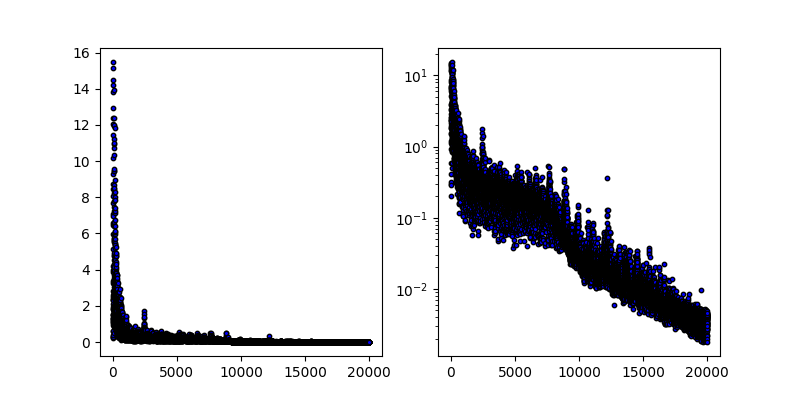

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(np.arange(len(losses)), losses, color='blue', edgecolors='black', s=10)
axs[1].scatter(np.arange(len(losses)), losses, color='blue', edgecolors='black', s=10)

axs[1].set_yscale('log')
# axs[1].set_xscale('log')

plt.show()

In [16]:
res = model.sample(y)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
# image_d(torch2np(res), cmap='hot')

In [18]:
# image_d(torch2np(x[0]) - torch2np(res), cmap='hot')